In [1]:
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, LagrangesMethod, Lagrangian
from sympy.physics import mechanics
init_vprinting()

In [2]:
def taylor(xpr, var, center, order=1):
    coefs = []
    t_xpr = 0
    for i in range(order + 1):
        coefs.append(xpr.subs(var, center))
        xpr = xpr.diff(var)
        t_xpr += var ** i * coefs[-1] / factorial(i)
    return t_xpr

def taylor_mat_entrywise(mat, lin_vars, lin_pt):
    slist = list(zip(lin_vars, lin_pt))
    
    A = mat.subs(slist)
    
    for i in range(len(lin_vars)):
        A += mat.diff(lin_vars[i]).subs(slist) * (lin_vars[i] - lin_pt[i])
    A.simplify()
    return A

In [3]:
# States:

x, phi = dynamicsymbols("x phi")
dx, dphi = dynamicsymbols("x phi", 1)
ddx, ddphi = dynamicsymbols("x phi", 2)
F, Tu, T1, T2 = symbols("F T_u T_1 T_2")
t = symbols("t")

q = Matrix([x, phi])
dq = q.diff(t)
ddq = dx.diff(t)

if True:
    h = 0.2
    r = 0.1193

    M = 0.62369
    m = 2.5
    
    gw = 9.8
    
    thw = rad(60)
    rw = 0.060/2

    rh = 0.15
    rr = 0.08
    A = m*h**2/12 * 1.5
    B = m*r**2/4
    I_robot = Matrix([[A+B, 0, 0], [0, A+B, 0], [0, 0, 2*B]])

    I = A
else:
    r, h, M, m, I, g = symbols("r h M m I g")
    
trig_subs = [(sin(phi), phi), (cos(phi), 1)]

In [4]:
T_ball = M*dx**2 / 2
T_robot = m/2*((dx + h*cos(phi)*dphi)**2 + (-h*sin(phi)*dphi)**2) + I/2*dphi**2
T_robot = T_robot.trigsimp()
V_ball = m*gw*h*cos(phi)

# T_robot = m/2*((dx - h*cos(phi)*dphi)**2 + m/2*(h*sin(phi)*dphi)**2) + I/2*dphi**2

L = T_ball + T_robot - V_ball
L

In [5]:
L.expand()

In [6]:
LHS = L.diff(dq).diff(t) - L.diff(q)
LHS = LHS.subs(trig_subs)
LHS

⎡         2                    ⎤
⎢- 0.5⋅φ⋅φ̇  + 0.5⋅φ̈ + 3.12369⋅ẍ⎥
⎢                              ⎥
⎣  -4.9⋅φ + 0.1125⋅φ̈ + 0.5⋅ẍ   ⎦

In [7]:
RHS = Matrix([F*cos(thw), -r*F]).subs(F, Tu/rw)
RHS.simplify()
RHS

⎡16.6666666666667⋅Tᵤ ⎤
⎢                    ⎥
⎣-3.97666666666667⋅Tᵤ⎦

In [8]:
eqs = [Eq(RHS[i], LHS[i]) for i in range(len(q))]
sln = solve(eqs, (ddx, ddphi), simplify=True)

In [9]:
Eq(ddx, sln[ddx].simplify())

In [10]:
Eq(ddphi, sln[ddphi].simplify())

In [11]:
LM = LagrangesMethod(L, [x, phi])

In [12]:
LM.form_lagranges_equations()

⎡              2                           ⎤
⎢- 0.5⋅sin(φ)⋅φ̇  + 0.5⋅cos(φ)⋅φ̈ + 3.12369⋅ẍ⎥
⎢                                          ⎥
⎣  -4.9⋅sin(φ) + 0.5⋅cos(φ)⋅ẍ + 0.1125⋅φ̈   ⎦

In [19]:
s = python(L)
print(s)

t = Symbol('t')
phi = Function('phi')
x = Function('x')
e = Float('0.5', precision=53)*cos(phi(t))*Derivative(phi(t), t)*Derivative(x(t), t) - Float('4.9000000000000004', precision=53)*cos(phi(t)) + Float('0.056249999999999994', precision=53)*Derivative(phi(t), t)**2 + Float('1.5618449999999999', precision=53)*Derivative(x(t), t)**2


In [23]:
with open("L_test.txt", 'w') as f:
    f.write(s)

In [18]:
help(dill)

Help on package dill:

NAME
    dill

DESCRIPTION
    -----------------------------
    dill: serialize all of python
    -----------------------------
    
    About Dill
    
    ``dill`` extends python's ``pickle`` module for serializing and de-serializing
    python objects to the majority of the built-in python types. Serialization
    is the process of converting an object to a byte stream, and the inverse
    of which is converting a byte stream back to a python object hierarchy.
    
    ``dill`` provides the user the same interface as the ``pickle`` module, and
    also includes some additional features. In addition to pickling python
    objects, ``dill`` provides the ability to save the state of an interpreter
    session in a single command.  Hence, it would be feasible to save an
    interpreter session, close the interpreter, ship the pickled file to
    another computer, open a new interpreter, unpickle the session and
    thus continue from the 'saved' state of the orig

# Stabilization

In [103]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

import control

def linearize(f, xs, q0):
    dfdq = Matrix(np.hstack(f.diff(X.T)[0])).subs([(xs[i], q0[i]) for i in range(len(xs))])
    dfdq.simplify()
    return dfdq

def Lie(f, V, var, order=1):
    if order > 1:
        return Lie(f, Lie(f, V, var, order-1), var)
    return sum([f[i] * V.diff(var[i]) for i in range(len(var))])

In [104]:
input_var = Tu

f = Matrix([[sln[ddx].subs(input_var, 0).simplify()],
            [dphi],
            [sln[ddphi].subs(input_var, 0).simplify()]])
g = Matrix([[sln[ddx].subs(phi, 0).subs(input_var, 1).simplify()], 
            [0], 
            [sln[ddphi].subs(phi, 0).subs(input_var, 1).simplify()]])

xs = (dx, phi, dphi)
Lf = lambda V, o=1: Lie(f, V, xs, o)
Lg = lambda V, o=1: Lie(g, V, xs, o)

X = Matrix([dx, phi, dphi])

q = Matrix([phi, dx, dphi])

In [105]:
ffn = lambdify(xs, np.array(f).T[0])
gfn = lambdify(xs, np.array(g).T[0])
def qdot(q, u):
    return ffn(*q) + gfn(*q) * u

A = np.array(linearize(f, X, [0, 0, 0]), dtype=float)
B = np.array(g, dtype=float)

# Feedback via Pole Placement
pole = -3
K = -control.place(A, B, [pole-0.1, pole, pole+0.1])

CAP = 0.8
goal = np.array([-1, 0, 0])
def u(q):
    return min(max((K @ (q - goal))[0], -CAP), CAP)


# Manually designed u(q)
# def u(q):
#     dx, phi, dphi = q
#     return (-17.8/0.8 - 10)*phi - 3*dphi - 0.3 *dx

TypeError: Cannot convert expression to float

In [106]:
Eq(MatrixSymbol('A', 3, 3), Matrix(A)), Eq(MatrixSymbol('B', 3, 1), Matrix(B))

TypeError: 
Data type not understood; expecting list of lists or lists of values.

In [42]:
Matrix(np.round(K, 2))

[0.01  4.15  0.07]

In [43]:
Eq(symbols('u'), (K * q)[0])

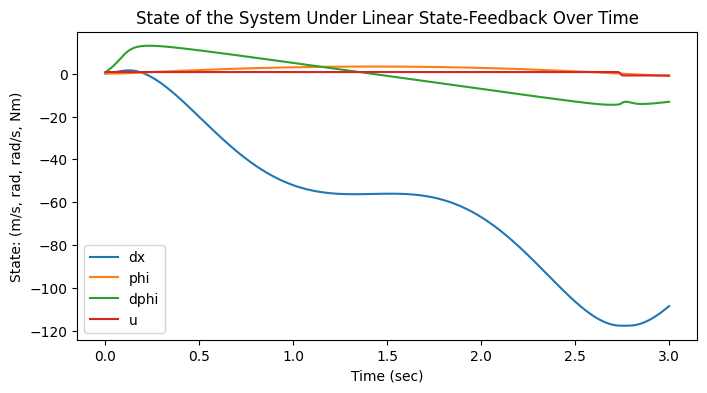

In [28]:
# Simulating the controller
q = np.array([0, 0.2, 0])
time = 0
dt = 0.01

ts = []
qs = []
us = []
while time <3:
    uval = u(q)
    q += qdot(q, uval) * dt
    qs.append(q.copy())
    us.append(uval)
    ts.append(time)
    time += dt

qs = np.array(qs)
us = np.array(us)

omg_w = (qs[:,0] + r*qs[:,2]) / rw * 30/3.14159

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)

plt.plot(ts, qs[:,0])
plt.plot(ts, qs[:,1]/pi)
plt.plot(ts, qs[:,2])
plt.plot(ts, us)
plt.legend(["dx", "phi", "dphi", "u"])
plt.ylabel("State: (m/s, rad, rad/s, Nm)")
plt.xlabel("Time (sec)")
plt.title("State of the System Under Linear State-Feedback Over Time")
plt.show()


# plt.plot(ts, omg_w)
# plt.xlabel("Time (sec)")
# plt.ylabel("RPM")
# plt.show()

In [56]:
float(deg(0.2))